In [25]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [26]:
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
sys.path.append("/Users/gregoirelejay/dev/personal/tag_walk/tag_walk") 

In [34]:
# import torchvision
# import matplotlib.pyplot as plt
# import numpy as np

# to_pl = transforms.ToPILImage()
# plt.imshow(to_pl(tw_dataset[0][0]))

# Inspecting the model

In [19]:
from fachung.models.tagwalk_classifier import TagWalkClassifier

BASIC_CONFIG = {
    'batch_size': 4,
    'num_epochs': 2,
    'output_dir': '../data/training_logs',
    'debug': False,
    'reset': False,
    'data_path': '../data/tag_walk/',
    'model_id': "306feb6"
}

tw_class = TagWalkClassifier(BASIC_CONFIG)
tw_class.read_model()

2017-09-08 00:21:04 Chromecast.home root[94629] INFO Trying to load ../data/training_logs/TagWalkClassifier__306feb6.pkl


Dataset sizes:
    Train:      (19516,)
    Validation: (4879,)
    Test:       (4879,)


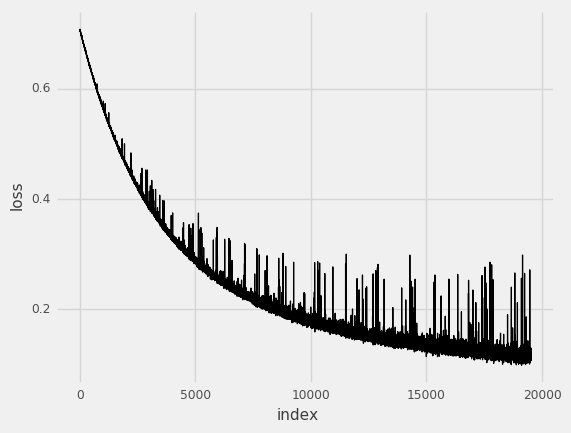

<ggplot: (-9223372036558118340)>

In [18]:
import plotnine as gg
import pandas as pd


df = pd.DataFrame({'loss':tw_class.history['loss']})
df['index'] = df.index
gg.ggplot(df) + gg.geom_line(gg.aes(x='index', y='loss')) + gg.theme_538()

In [23]:
test_loader = tw_class.loader_dict['testing']
model = tw_class.model
classes = tw_class.classes

to_pl = transforms.ToPILImage()

import torch.nn.functional as F

model.eval()

def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(test_loader):
        inputs, labels, img_path = data
        inputs, labels = Variable(inputs), Variable(labels)

        outputs = F.sigmoid(model(inputs))
        print(outputs)
        print(F.sigmoid(outputs))
        _, preds = torch.max(outputs.data, 1)
        
        output_mat = outputs.data.cpu().numpy()
        target_mat = labels.data.cpu().numpy()
        for batch_id in range(output_mat.shape[0]):
            print("-------")
            max_idx = np.argpartition(output_mat[batch_id], 10)[:10]
            print(max_idx)
            print("IMG: %s \n Predicted: %s \n Truth: %s" % (
                img_path[batch_id],
                classes[max_idx],
                classes[
                    np.where(target_mat[batch_id] == 1)
                ]))
            print("ALT:")
            max_idx = np.where(output_mat[batch_id] > 0.5)
            print(max_idx)
            print("IMG: %s \n Predicted: %s \n Truth: %s" % (
                img_path[batch_id],
                classes[max_idx],
                classes[
                    np.where(target_mat[batch_id] == 1)
                ]))
        break

In [24]:
visualize_model(model)

Variable containing:
 0.0458  0.0572  0.0484  ...   0.0456  0.0632  0.0758
 0.0528  0.0655  0.0768  ...   0.0480  0.0862  0.0672
 0.0911  0.0653  0.0551  ...   0.0934  0.0749  0.1201
 0.1250  0.0914  0.0855  ...   0.1250  0.1152  0.1153
[torch.FloatTensor of size 4x655]

Variable containing:
 0.5114  0.5143  0.5121  ...   0.5114  0.5158  0.5189
 0.5132  0.5164  0.5192  ...   0.5120  0.5215  0.5168
 0.5228  0.5163  0.5138  ...   0.5233  0.5187  0.5300
 0.5312  0.5228  0.5214  ...   0.5312  0.5288  0.5288
[torch.FloatTensor of size 4x655]

-------
[449  24  17 157 561 330  68 338 351 293]
IMG: ../data/tag_walk/images/all/LOOK20.jpg 
 Predicted: ['pink-trousers' 'autumn' 'architecture' 'crochet' 'stones' 'large'
 'bleached-denim' 'leather-pants' 'logo-tee-shirt' 'horizontal-stripes'] 
 Truth: ['blue' 'embellishment' 'floral' 'nautical' 'navy-blue' 'pants' 'pattern'
 'seaside' 'shoulder-pads' 'top' 'trousers']
ALT:
(array([], dtype=int64),)
IMG: ../data/tag_walk/images/all/LOOK20.jpg 
 Pre

In [63]:
from graphviz import Digraph
import re
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models


def make_dot(var, params):
    param_map = {id(v): k for k, v in params.items()}
    
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()
    
    def size_to_str(size):
        return '('+(', ').join(['%d'% v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                node_name = '%s\n %s' % (param_map.get(id(u)), size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

In [75]:
print(model)

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [90]:
feature_extractor = nn.Sequential(*list(model.children())[:-2])
class_weighter = nn.Sequential(*list(model.children())[:-1])

In [95]:
import numpy as np
for i, data in enumerate(test_loader):
    inputs, labels, img_path = data
    inputs, labels = Variable(inputs), Variable(labels)

    outputs = feature_extractor(inputs)
    class_weights = class_weighter(inputs)
    conv_outputs = outputs[0].data.cpu().numpy()
    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
#     print(cam)
#     print(class_weights)
    target_class = 1
    for i, w in enumerate(class_weights[:, target_class]):
        cam +=  conv_outputs[i, :, :]
    print(cam)
    break

[[ 3.87931633  5.43117428  6.84020615  6.50841045  5.09973955  4.35748005
   3.21372366]
 [ 5.29686403  7.32127953  6.90454388  7.26271152  3.27393198  5.13797903
   5.78631496]
 [ 5.2273345   8.31282234  9.40685463  7.79715776  4.04397964  4.48907471
   4.51025343]
 [ 5.0350976   7.98308754  8.39721012  6.66860056  2.60615182  3.08070183
   2.16655469]
 [ 6.47694683  9.47051239  4.96564531  4.74222994  1.97507548  0.4090479
   0.23092116]
 [ 8.03375721  8.06864262  3.47712088  3.40786695  1.78303087  1.82380354
   2.00484848]
 [ 5.27673721  5.5357976   3.49029684  2.52119875  0.68547672  0.
   0.70518965]]


In [36]:
from fachung.datasets.tagwalk import TagwalkSequenceDataset

NORMALIZE = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

DEFAULT_TRANSFORMS = (
    transforms.Compose([
        # transforms.RandomSizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.Scale((224, 224)),
        transforms.ToTensor(),
        NORMALIZE
    ])
)

dataset = TagwalkSequenceDataset(
    csv_path='../data/tag_walk/' + 'assocs.csv',
    img_path='../data/tag_walk/' + 'images/all',
    transform=DEFAULT_TRANSFORMS
)

In [65]:
import json
import fachung.logger as logger
from fachung.models.tagwalk_cnn_rnn import TagWalkCNNRNN

model_cls = TagWalkCNNRNN
logger.INFO("Using model: %s" % model_cls.__name__)

configuration = {
  "batch_size": 4,
  "num_epochs": 5,
  "output_dir": "../data/training_logs",
  "debug": False,
  "reset": False,
  "data_path": "../data/tag_walk/",
  "model_id": "4b7c7d0",
  "options": {
     "embedding_size": 32,
     "hidden_size": 256,
     "num_layers": 4,
     "learning_rate": 0.0001
  }
}
logger.INFO("Using Configuration %s" % configuration)

engine = model_cls(configuration)

2017-09-09 13:12:44 Chromecast.home root[94629] INFO Using model: TagWalkCNNRNN
2017-09-09 13:12:44 Chromecast.home root[94629] INFO Using Configuration {'batch_size': 4, 'num_epochs': 5, 'output_dir': '../data/training_logs', 'debug': False, 'reset': False, 'data_path': '../data/tag_walk/', 'model_id': '4b7c7d0', 'options': {'embedding_size': 32, 'hidden_size': 256, 'num_layers': 4, 'learning_rate': 0.0001}}


Dataset sizes:
    Train:      (19516,)
    Validation: (4879,)
    Test:       (4879,)


In [66]:
engine.read_model()

2017-09-09 13:12:56 Chromecast.home root[94629] INFO Trying to load ../data/training_logs/TagWalkCNNRNN__4b7c7d0.pkl


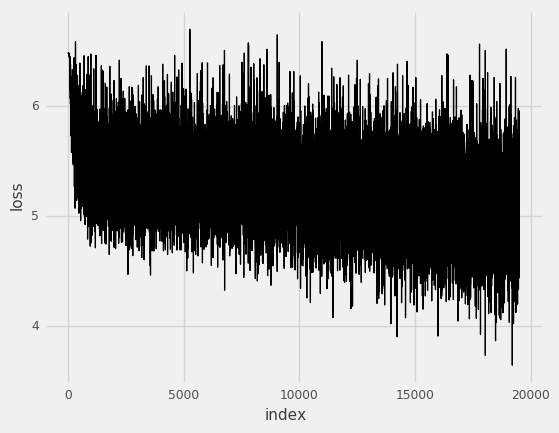

<ggplot: (-9223372036493922500)>

In [67]:
import plotnine as gg
import pandas as pd


df = pd.DataFrame({'loss': engine.history['metrics']['loss']})
df['index'] = df.index
gg.ggplot(df) + gg.geom_line(gg.aes(x='index', y='loss')) + gg.theme_538()

In [48]:
engine.set_eval()


In [58]:
test_loader = engine.loader_dict['testing']
model = engine.model
classes = engine.classes

to_pl = transforms.ToPILImage()

import torch.nn.functional as F

engine.set_eval()

def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(test_loader):
        inputs, labels, img_path = data
        inputs, labels = Variable(inputs), Variable(labels)

        features = model['encoder'](inputs)
        print(features)
        sampled_ids = model['decoder'].sample(features)
        sampled_ids = sampled_ids.cpu().data.numpy()
        
        print(sampled_ids)
        
#         output_mat = outputs.data.cpu().numpy()
#         target_mat = labels.data.cpu().numpy()
#         for batch_id in range(output_mat.shape[0]):
#             print("-------")
#             max_idx = np.argpartition(output_mat[batch_id], 10)[:10]
#             print(max_idx)
#             print("IMG: %s \n Predicted: %s \n Truth: %s" % (
#                 img_path[batch_id],
#                 classes[max_idx],
#                 classes[
#                     np.where(target_mat[batch_id] == 1)
#                 ]))

In [59]:
visualize_model(model)

Variable containing:

Columns 0 to 9 
-0.2120 -0.0419 -1.5370 -0.9910  0.3837  0.4193  0.1516  0.0629  0.6004  0.2429
 0.0945 -1.5634 -1.5221  0.7406 -0.5580  1.4100  0.1921  0.1007  0.8975  0.2578
-0.2598 -0.6934 -0.1542 -1.1136 -0.4940  0.7202 -0.0760  0.0825 -0.2599  0.2118
-0.7743  0.3340  1.5609 -0.5203  0.2368  0.1067 -0.0942  0.0828  0.3460  0.3252

Columns 10 to 19 
 0.2171 -0.8307  1.1645  0.1266 -0.8633  0.2437  0.2325 -0.2262 -0.7085 -0.5808
 0.4461  2.0557  0.9758 -0.0058 -1.9582  0.2509  0.3097 -0.2156  1.0394 -0.5031
 0.1923  0.5118 -0.0553 -0.2119 -0.0542  0.0781 -0.0107 -0.4640 -1.5188  0.9283
 0.0868 -0.1702 -0.8935 -0.1722  1.5156  0.1059  0.3036 -0.4818  0.7752 -0.3491

Columns 20 to 29 
 0.2457 -2.4736  1.3164 -0.1536 -0.9111 -0.9791  0.1319 -0.6727 -0.4766  0.1313
-0.2757 -0.9852  0.2402  0.1055 -0.3595 -1.0346 -0.0597  0.1363 -0.3008 -0.1135
 0.0262 -0.6600 -0.1150 -0.1724  0.2149 -0.2906  0.1038 -0.3885  0.1498  0.0365
-1.2116  0.2780 -0.6313 -0.0167 -0.8591  0.8

RuntimeError: size mismatch, m1: [1 x 4], m2: [32 x 1024] at /Users/soumith/code/builder/wheel/pytorch-src/torch/lib/TH/generic/THTensorMath.c:1293